In [3]:
import torch
from monai.transforms import RandAffine, Rand3DElastic, RandGaussianSmooth

In [4]:
if torch.backends.mps.is_available():
    print("MPS is available.")
    device = torch.device("mps")
elif torch.cuda.is_available():
    print("CUDA is available.")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

print("device: {}".format(device))

CUDA is available.
device: cuda


In [47]:
import numpy as np
import nibabel as nib
from scipy import ndimage
import os
from typing import Dict, List, Tuple, Optional, Union
import SimpleITK as sitk
from skimage.transform import resize
import multiprocessing as mp
from functools import partial
import time
import logging
from scipy.ndimage import gaussian_filter
import random
from tqdm import tqdm
import concurrent.futures
import torch.nn.functional as F
import re
import torch
from monai.transforms import (
    RandAffine,
    Rand3DElastic,
    SpatialPad,
    CenterSpatialCrop,
    ScaleIntensityRange
)

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('preprocessing.log')
    ]
)

In [48]:
class ImageStandardizer:
    """Handle image standardization with consistent spacing and orientation"""   
    def __init__(self, target_spacing: Tuple[float, float, float] = (1.0, 1.0, 1.0),
                 target_size: Tuple[int, int, int] = (240, 240, 155),
                 target_direction: Tuple[float, ...] = (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)):
        self.target_spacing = target_spacing
        self.target_size = target_size
        self.target_direction = target_direction
    def standardize_image(self, image_path: str, return_tensor: bool = False, device: str = 'cpu') -> Union[np.ndarray, torch.Tensor,Dict]:
        # Load image with SimpleITK to preserve metadata
        image = sitk.ReadImage(image_path)    
        # Store original metadata
        original_metadata = {
            'spacing': image.GetSpacing(),
            'direction': image.GetDirection(),
            'origin': image.GetOrigin(),
            'size': image.GetSize()
        }
        size = image.GetSize()
        spacing = image.GetSpacing()
        #origin = image.GetOrigin()
        new_size = [round(size[0] * spacing[0]/self.target_spacing[0]), 
                    round(size[1] * spacing[1]/self.target_spacing[1]), 
                    round(size[2] * spacing[2]/self.target_spacing[2])]
        corners = [[0,0,0],[0,0, size[2]-1],[0,size[1]-1,0],[0,size[1]-1,size[2]-1],
                   [size[0]-1,0,0], [size[0]-1, 0, size[2]-1], [size[0]-1,size[1]-1,0],
                   [size[0]-1, size[1]-1, size[2]-1]]
        physical_corners = [np.array(image.TransformIndexToPhysicalPoint(corner)) for corner in corners]
        min_physical_point = np.min(physical_corners, axis=0)
        # Set the new origin as the minimum physical point
        new_origin = min_physical_point
        # Resample to target spacing
        resampler = sitk.ResampleImageFilter()
        resampler.SetOutputSpacing(self.target_spacing)
        resampler.SetOutputDirection(self.target_direction)
        resampler.SetOutputOrigin(new_origin)
        resampler.SetSize(new_size)
        resampler.SetInterpolator(sitk.sitkLinear)
        print("Original array shape: ", image.GetSize())
        standardized_image = resampler.Execute(image)
        
        standardized_array = sitk.GetArrayFromImage(standardized_image)
        # Rearrange dimensions to match original shape 
        #standardized_array = np.transpose(standardized_array, (2, 1,0))
        # Check numpy array orientation 
        print("Standardized array shape: ", standardized_array.shape)
        if return_tensor:
            standardized_tensor = torch.tensor(standardized_array, dtype=torch.float32).unsqueeze(0).to(device)  # Shape (1, D, H, W)
            print("Standardized tensor shape: ", standardized_tensor.shape)
            return standardized_tensor, original_metadata
        else:
            return standardized_array, original_metadata

In [78]:
class AugmentationTransforms:
    """Handle various image augmentation transforms optimized for brain pediatric MRI data"""

    @staticmethod
    def random_affine_transform(
        image: torch.Tensor, 
        rotation_range: Tuple[float, float, float] = (np.pi/90, np.pi/90, np.pi/90),  # ±2° rotation
        scale_range: Tuple[float, float, float] = (0.01, 0.01, 0.01),  # Minimal scaling
        translation_range: Tuple[float, float, float] = (5, 5, 2),  # Small translations
        seed: Optional[int] = None
    ) -> torch.Tensor:
        if seed is not None:
            torch.manual_seed(seed)
        
        # Calculate padding size
        max_dim = max(image.shape[1:])
        pad_size = int(max_dim * 0.6)  # Use 60% padding to ensure no features are cut

        # Padding and cropping transforms
        padder = SpatialPad(
            spatial_size=[d + 2 * pad_size for d in image.shape[1:]],
            mode="edge"  # Use edge padding to preserve structures
        )
        cropper = CenterSpatialCrop(roi_size=image.shape[1:])

        # Constrained affine transformation with "nearest" interpolation
        affine_transform = RandAffine(
            prob=1.0,
            rotate_range=rotation_range,
            scale_range=scale_range,
            translate_range=translation_range,
            mode="nearest",  # Use nearest interpolation
            padding_mode="border",
            cache_grid=True
        )

        # Apply transformations without intensity normalization
        padded_image = padder(image)
        transformed_image = affine_transform(padded_image)
        final_image = cropper(transformed_image)
        
        return final_image

    @staticmethod
    def elastic_deformation(
        image: torch.Tensor, 
        alpha: float = 20.0,  # Gentler deformation
        sigma: float = 4.0,  # Smoother deformation
        seed: Optional[int] = None
    ) -> torch.Tensor:
        if seed is not None:
            torch.manual_seed(seed)
        
        # Elastic transform with "nearest" interpolation
        elastic_transform = Rand3DElastic(
            prob=1.0,
            sigma_range=(sigma, sigma),
            magnitude_range=(alpha, alpha),
            spatial_size=image.shape[1:],
            mode="nearest",  # Use nearest interpolation
            padding_mode="zeros",
        )

        # Apply elastic transformation without intensity normalization
        transformed_image = elastic_transform(image)
        
        return transformed_image


Original array shape:  (240, 240, 155)
Standardized array shape:  (155, 240, 240)
Standardized tensor shape:  torch.Size([1, 155, 240, 240])
Shape after standardization:  torch.Size([155, 240, 240])
Vol shape: (155, 240, 240)
Vol shape: (155, 240, 240)
Vol shape: (155, 240, 240)


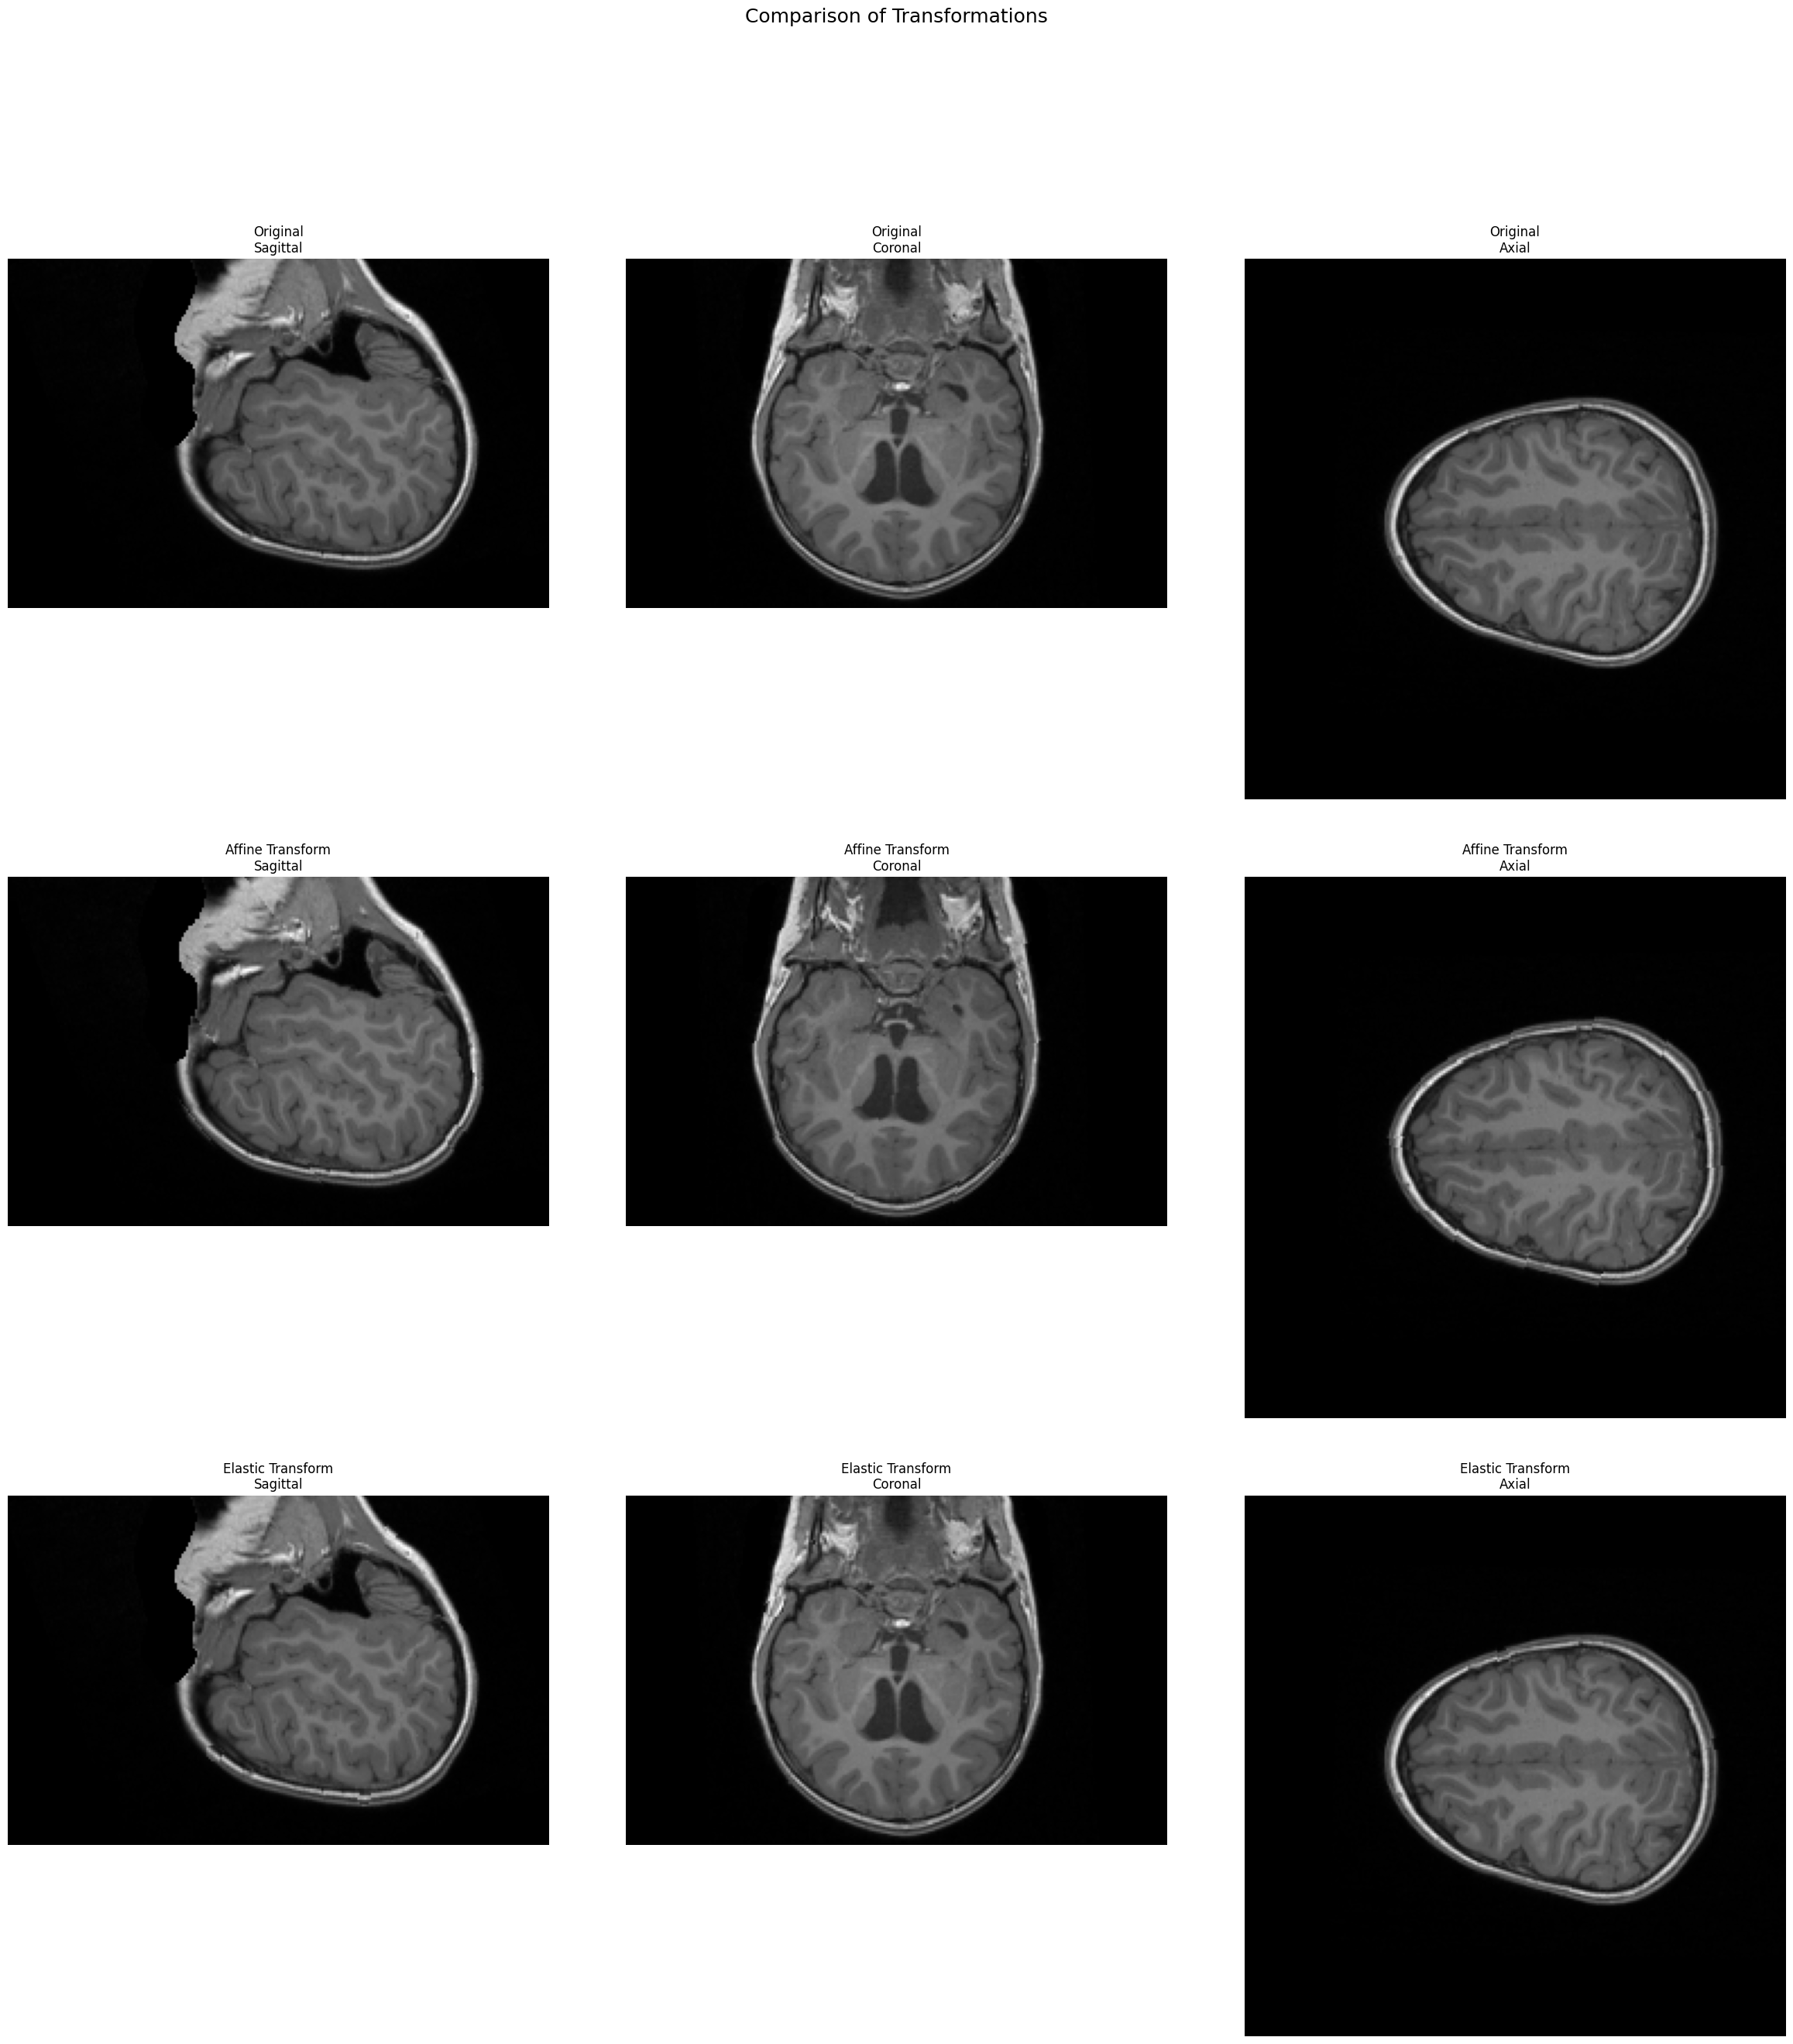

In [79]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def visualize_transformations(image_path: str):
    """
    Visualize original image alongside affine and elastic transformations.
    Shows middle slices of the 3D volume in all three planes.
    """
    # Initialize standardizer and augmenter
    standardizer = ImageStandardizer()
    augmenter = AugmentationTransforms()
    
    # Load and standardize image
    image_data, metadata = standardizer.standardize_image(image_path, return_tensor=True, device='cuda')  # Load directly on GPU
    image_data = image_data.squeeze(0)
    print("Shape after standardization: ", image_data.shape)
    
    # Apply affine transformation using nearest-neighbor interpolation
    affine_transformed = augmenter.random_affine_transform(
        image_data.unsqueeze(0),
        rotation_range=(np.pi/90, np.pi/90, np.pi/90),  # ±2° rotation
        scale_range=(0.01, 0.01, 0.01),  # Minimal scaling
        translation_range=(5, 5, 2),  # Small translations
        seed=1
    ).squeeze(0)
    
    # Apply elastic deformation using nearest-neighbor interpolation
    elastic_transformed = augmenter.elastic_deformation(
        image_data.unsqueeze(0),
        alpha=20.0,  # Gentler deformation
        sigma=4.0,   # Smoother deformation
        seed=1
    ).squeeze(0)
    
    # Get middle slices for each plane
    def get_middle_slices(vol, crop_size: Tuple[int, int] = (128, 128)) -> Dict[str, np.ndarray]:
        vol = vol.cpu().numpy()  # Convert to numpy for visualization
        x, y, z = vol.shape
        print("Vol shape:", vol.shape)

        return {
            'Sagittal': vol[:, :, x // 2],
            'Coronal': vol[:, y // 2, :],
            'Axial': np.rot90(vol[z // 2, :, :])
        }  
        
    # Extract slices from the original and transformed images
    original_slices = get_middle_slices(image_data)
    affine_slices = get_middle_slices(affine_transformed)
    elastic_slices = get_middle_slices(elastic_transformed)
    
    # Create a figure with ImageGrid
    fig = plt.figure(figsize=(27, 27))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(3, 3),
                     axes_pad=1.0,
                     share_all=True)
    
    # Plot all slices
    for idx, plane in enumerate(['Sagittal', 'Coronal', 'Axial']):
        # Original
        grid[idx].imshow(original_slices[plane], cmap='gray')
        grid[idx].set_title(f'Original\n{plane}')
        
        # Affine
        grid[idx + 3].imshow(affine_slices[plane], cmap='gray')
        grid[idx + 3].set_title(f'Affine Transform\n{plane}')
        
        # Elastic
        grid[idx + 6].imshow(elastic_slices[plane], cmap='gray')
        grid[idx + 6].set_title(f'Elastic Transform\n{plane}')
    
    # Remove axes for a cleaner look
    for ax in grid:
        ax.axis('off')
    
    plt.suptitle('Comparison of Transformations', fontsize=18, y=1.02)
    fig.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.05, wspace=0.2, hspace=0.2)
    plt.show()

# Example usage:
image_path = "BraTS-PEDs2024_Training/BraTS-PED-00002-000/BraTS-PED-00002-000-t1n.nii.gz"  # Replace with actual path
visualize_transformations(image_path)

In [40]:
def load_nifti(file_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load a NIfTI file and return the image data."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    nifti = nib.load(file_path)
    image_data = nifti.get_fdata(dtype=np.float32)  # Ensure consistent dtype
    affine = nifti.affine  # Retain affine matrix for spatial info
    return image_data, affine

def normalize_intensity(image: np.ndarray, mask: np.ndarray = None, clip_range: Tuple[float, float] = (-3, 3)) -> np.ndarray:
    """Normalize the intensity of the image using Z-score normalization and optionally clip the values."""
    if mask is None:
        mask = image > image.mean()
    
    mean = image[mask].mean()
    std = image[mask].std()
    normalized = (image - mean) / (std + 1e-8)
    
    # Optionally clip the intensity values to the specified range
    normalized = np.clip(normalized, clip_range[0], clip_range[1])
    
    return normalized.astype(np.float32)

def apply_bias_field_correction(image: np.ndarray) -> np.ndarray:
    """"Apply N4 bias field correction using SimpleITK with default parameters."""
    sitk_image = sitk.GetImageFromArray(image)
    mask = sitk.OtsuThreshold(sitk_image)
    
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    # Using default parameters
    
    try:
        corrected_image = corrector.Execute(sitk_image, mask)
        return sitk.GetArrayFromImage(corrected_image)
    except RuntimeError as e:
        logging.warning(f"Bias field correction failed: {str(e)}. Returning original image.")
        return image


def resize_volume(image: np.ndarray, output_shape: Tuple[int, int, int]) -> np.ndarray:
    """Resize the volume to a standard size."""
    return resize(image.astype(np.float32), output_shape, mode='constant', anti_aliasing=True)

In [41]:
def extract_numeric_id(patient_id: str) -> int:
    match = re.search(r'\d+', patient_id)
    if match:
        return int(match.group())
    else:
        raise ValueError("No numeric ID found in patient_id")
        
def preprocess_single_modality(
    image_path: str,
    modality: str,
    standardizer: ImageStandardizer,
    augmenter: AugmentationTransforms,
    apply_augmentation: bool = False,
    seg_image: Optional[np.ndarray] = None,
    patient_id: str = "",
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> List[Tuple[str, np.ndarray, Dict]]:
    """
    Process a single modality and generate augmented versions if requested.
    Always keeps the original preprocessed version.
    """
    try:
        results = []
        # Standardize original image
        image_data, metadata = standardizer.standardize_image(image_path)
        # Calculate a consistent seed for transformations based on patient ID
        numeric_id = extract_numeric_id(patient_id)
        patient_seed = 1000 + numeric_id
        
        # Apply preprocessing for non-segmentation images
        if modality != 'seg':
            # Bias field correction and normalization for original
            preprocessed_image = apply_bias_field_correction(image_data)
            preprocessed_image = normalize_intensity(preprocessed_image)
            
            # Save original preprocessed version (without augmentation)
            results.append((f"{modality}_orig", preprocessed_image, metadata))
            
            # Generate augmented versions if requested
            if apply_augmentation:
                # Apply affine transformation
                affine_image = augmenter.random_affine_transform(preprocessed_image, seed = patient_seed)
                results.append((f"{modality}_affine", affine_image, metadata))
                
                # Apply elastic deformation
                elastic_image = augmenter.elastic_deformation(preprocessed_image, seed = patient_seed)
                results.append((f"{modality}_elastic", elastic_image, metadata))
                
                # Apply the same transformations to the segmentation mask
                if seg_image is not None:
                    affine_seg = augmenter.random_affine_transform(seg_image, seed = patient_seed)
                    results.append((f"seg_affine", affine_seg, metadata))
                    
                    elastic_seg = augmenter.elastic_deformation(seg_image, seed = patient_seed)
                    results.append((f"seg_elastic", elastic_seg, metadata))
        else:
            # For segmentation masks, only store original version
            results.append((f"{modality}_orig", image_data, metadata))
        
        logging.info(f"Successfully processed {os.path.basename(image_path)}")
        return results
        
    except Exception as e:
        logging.error(f"Error processing {image_path}: {str(e)}")
        return [(f"{modality}_orig", None, None)]

In [42]:
def preprocess_patient_data_parallel(
    data_dir: str,
    patient_id: str,
    standardizer: ImageStandardizer,
    augmenter: AugmentationTransforms,
    apply_augmentation: bool = False,
    num_processes: int = None,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> Dict[str, Tuple[np.ndarray, Dict]]:
    """
    Preprocess all modalities for a single patient using parallel processing.
    """
    patient_folder = os.path.join(data_dir, patient_id)
    # Define file paths with progress tracking
    modalities = ['t1n', 't1c', 't2f', 't2w']
    seg_path = os.path.join(patient_folder, f'{patient_id}-seg.nii.gz')
    seg_image, seg_metadata = standardizer.standardize_image(seg_path) 
    file_paths = {
        mod: os.path.join(patient_folder, f'{patient_id}-{mod}.nii.gz')
        for mod in modalities
    }
    # Process each modality with progress bar
    results = {}
    with tqdm(total=len(modalities), desc=f"Processing {patient_id}", leave=True) as pbar:
        for modality, filepath in file_paths.items():
            # Now handle the list of results properly
            processed_results = preprocess_single_modality(
                filepath, 
                modality,
                standardizer,
                augmenter,
                apply_augmentation,
                seg_image=seg_image,
                patient_id=patient_id
            )           
            # Add each result to the dictionary
            for mod_name, img, meta in processed_results:
                if img is not None:
                    results[mod_name] = (img, meta)
            
            pbar.update(1)
            pbar.set_postfix({'current_file': os.path.basename(filepath)})   
    return results

In [43]:
import os
import logging
from concurrent.futures import ProcessPoolExecutor, as_completed

def process_modality(
    filepath: str, 
    modality: str, 
    standardizer: ImageStandardizer, 
    augmenter: AugmentationTransforms, 
    apply_augmentation: bool, 
    seg_image: Optional[np.ndarray], 
    patient_id: str, 
    device: str
) -> List[Tuple[str, np.ndarray, Dict]]:
    """Standalone function to process a single modality."""
    return preprocess_single_modality(
        image_path=filepath,
        modality=modality,
        standardizer=standardizer,
        augmenter=augmenter,
        apply_augmentation=apply_augmentation,
        seg_image=seg_image,
        patient_id=patient_id,
        device=device
    )

def preprocess_patient_data_parallel(
    data_dir: str,
    patient_id: str,
    standardizer: ImageStandardizer,
    augmenter: AugmentationTransforms,
    apply_augmentation: bool = False,
    num_processes: int = None,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> Dict[str, Tuple[np.ndarray, Dict]]:
    """
    Preprocess all modalities for a single patient using parallel processing.
    """
    patient_folder = os.path.join(data_dir, patient_id)
    
    # Define file paths for each modality
    modalities = ['t1n', 't1c', 't2f', 't2w']
    seg_path = os.path.join(patient_folder, f'{patient_id}-seg.nii.gz')
    
    # Check if segmentation file exists
    seg_image, seg_metadata = None, None
    if os.path.exists(seg_path):
        seg_image, seg_metadata = standardizer.standardize_image(seg_path)
    
    file_paths = {
        mod: os.path.join(patient_folder, f'{patient_id}-{mod}.nii.gz')
        for mod in modalities
    }
    
    results = {}

    # Process each modality in parallel with a progress bar
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        futures = {
            executor.submit(process_modality, path, mod, standardizer, augmenter, apply_augmentation, seg_image, patient_id, device): mod
            for mod, path in file_paths.items()
        }
        
        with tqdm(total=len(futures), desc=f"Processing {patient_id}", leave=True) as pbar:
            for future in as_completed(futures):
                modality = futures[future]
                try:
                    processed_results = future.result()
                    # Add each result to the dictionary
                    for mod_name, img, meta in processed_results:
                        if img is not None:
                            results[mod_name] = (img, meta)
                except Exception as e:
                    logging.error(f"Error processing {modality} for {patient_id}: {str(e)}")
                
                pbar.update(1)
                pbar.set_postfix({'current_file': modality})
    
    return results


In [44]:
def save_preprocessed_data(
    output_dir: str,
    patient_id: str,
    preprocessed_data: Dict[str, Tuple[np.ndarray, Dict]]
) -> None:
    """
    Save preprocessed data including both original and augmented versions.
    """
    patient_output_dir = os.path.join(output_dir, patient_id)
    os.makedirs(patient_output_dir, exist_ok=True)
    
    for modality, (image, metadata) in preprocessed_data.items():
        try:
            # Convert image to NumPy array if it is a PyTorch tensor
            if isinstance(image, torch.Tensor):
                image = image.cpu().numpy()
            # Create output filename
            if '_orig' in modality:
                # Original preprocessed version
                base_mod = modality.replace('_orig', '')
                output_filename = f"{patient_id}-{base_mod}_preprocessed.nii.gz"
            elif '_aug_' in modality:
                # Augmented version
                base_mod, aug_num = modality.rsplit('_aug_', 1)
                output_filename = f"{patient_id}-{base_mod}_aug{aug_num}.nii.gz"
            else:
                output_filename = f"{patient_id}-{modality}.nii.gz"
                
            # Create and save NIfTI image
            nifti_image = nib.Nifti1Image(
                image.astype(np.float32),  
                affine=np.eye(4) if 'affine' not in metadata else metadata['affine']
            )
            
            # Set header information
            header = nifti_image.header
            if metadata and 'spacing' in metadata:
                header.set_zooms(metadata['spacing'])
            header.set_sform(np.eye(4))
            header.set_qform(np.eye(4))
            
            output_path = os.path.join(patient_output_dir, output_filename)
            nib.save(nifti_image, output_path)
            
            logging.info(f"Saved {output_filename}")
            
        except Exception as e:
            logging.error(f"Error saving {modality} for {patient_id}: {str(e)}")
            continue

In [45]:
def preprocess_dataset_parallel(
    root_dir: str,
    output_dir: str,
    target_spacing: Tuple[float, float, float] = (1.0, 1.0, 1.0),
    target_size: Tuple[int, int, int] = (240, 240, 155),
    apply_augmentation: bool = False,
    num_processes: int = None,
    batch_size: int = 4,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
) -> None:
    """
    Optimized version of dataset preprocessing
    """
    # Initialize standardizer and augmenter
    standardizer = ImageStandardizer(
        target_spacing=target_spacing,
        target_size=target_size
    )
    augmenter = AugmentationTransforms()
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Get training directory path
    training_dir = os.path.join(root_dir, 'BraTS-PEDs2024_Training')
    
    # Get list of all patient IDs
    patient_ids = [d for d in os.listdir(training_dir) 
                  if os.path.isdir(os.path.join(training_dir, d))]
    
    logging.info(f"Found {len(patient_ids)} patients to process")
    
    # Create main progress bar
    with tqdm(total=len(patient_ids), desc="Overall Progress", position=0) as main_pbar:
        # Use ThreadPoolExecutor for I/O-bound operations
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_processes) as executor:
            for i in range(0, len(patient_ids), batch_size):
                batch = patient_ids[i:i + batch_size]
                futures = []
                
                for patient_id in batch:
                    logging.info(f"Starting preprocessing for {patient_id}")
                    future = executor.submit(
                        preprocess_patient_data_parallel,
                        training_dir,
                        patient_id,
                        standardizer,
                        augmenter,
                        apply_augmentation,
                        num_processes
                    )
                    futures.append((patient_id, future))
                
                # Process results as they complete
                for patient_id, future in futures:
                    try:
                        preprocessed_data = future.result()
                        if preprocessed_data:
                            save_preprocessed_data(output_dir, patient_id, preprocessed_data)
                            logging.info(f"Completed processing and saving {patient_id}")
                    except Exception as e:
                        logging.error(f"Failed to process {patient_id}: {str(e)}")
                    finally:
                        main_pbar.update(1)

In [ ]:
# Record start time
start_time = time.time()
# Determine device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Run preprocessing with augmentation
preprocess_dataset_parallel(
    root_dir='data/training_images',
    output_dir='preprocessed_brats2024_data',
    target_spacing=(1.0, 1.0, 1.0),
    target_size=(240, 240, 155),
    apply_augmentation=True,
    #num_processes=mp.cpu_count(),  # Use all available CPU core
    batch_size=2,
    device = device
)

# Print completion time
elapsed_time = time.time() - start_time
logging.info(f"Preprocessing completed in {elapsed_time:.2f} seconds")

2024-10-30 19:45:24,886 - INFO - Found 261 patients to process
Overall Progress:   0%|          | 0/261 [00:00<?, ?it/s]2024-10-30 19:45:24,888 - INFO - Starting preprocessing for BraTS-PED-00196-000
2024-10-30 19:45:24,890 - INFO - Starting preprocessing for BraTS-PED-00250-000

Processing BraTS-PED-00196-000:   0%|          | 0/4 [00:00<?, ?it/s]

Processing BraTS-PED-00250-000:   0%|          | 0/4 [00:00<?, ?it/s]2024-10-30 19:46:19,871 - INFO - Successfully processed BraTS-PED-00196-000-t1c.nii.gz

Processing BraTS-PED-00196-000:  25%|██▌       | 1/4 [00:50<02:30, 50.20s/it, current_file=t1c]2024-10-30 19:46:27,247 - INFO - Successfully processed BraTS-PED-00196-000-t2f.nii.gz
2024-10-30 19:46:27,854 - INFO - Successfully processed BraTS-PED-00196-000-t1n.nii.gz

Processing BraTS-PED-00196-000:  75%|███████▌  | 3/4 [00:58<00:13, 13.92s/it, current_file=t1n]2024-10-30 19:46:29,020 - INFO - Successfully processed BraTS-PED-00250-000-t1c.nii.gz
2024-10-30 19:46:29,994 - INFO - Succes